In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d biaiscience/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
License(s): DbCL-1.0
 97% 791M/817M [00:03<00:00, 242MB/s]
100% 817M/817M [00:03<00:00, 224MB/s]


In [3]:
import zipfile
import os

file_path = '/content/dogs-vs-cats.zip'
print(f"Attempting to open file: {file_path}")

zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Attempting to open file: /content/dogs-vs-cats.zip


In [4]:
import os
import shutil
import random

# 1. CLEAN UP THE OLD, MESSED-UP DIRECTORY
# This is crucial to start fresh
import shutil
if os.path.exists('/content/sorted_pets'):
    shutil.rmtree('/content/sorted_pets')
    print("Removed old sorted_pets directory to start fresh.")

# 2. DEFINE PATHS
original_data_dir = '/content/train/train'
base_dir = '/content/sorted_pets'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Create the new directory structure
os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)
os.makedirs(validation_cats_dir, exist_ok=True)
os.makedirs(validation_dogs_dir, exist_ok=True)

# 3. GET AND SHUFFLE THE FILE LIST
image_extensions = ('.jpg', '.jpeg', '.png')
fnames = [f for f in os.listdir(original_data_dir)
          if os.path.isfile(os.path.join(original_data_dir, f)) and f.lower().endswith(image_extensions)]

print(f"Found {len(fnames)} images in '{original_data_dir}'.")

# Shuffle the list for a balanced split
random.seed(42)
random.shuffle(fnames)

# 4. SPLIT THE DATA
split_index = int(0.8 * len(fnames))
train_fnames = fnames[:split_index]
validation_fnames = fnames[split_index:]

print(f"Using {len(train_fnames)} images for training.")
print(f"Using {len(validation_fnames)} images for validation.")

# 5. COPY FILES WITH PROGRESS FEEDBACK
def copy_file_list(file_list, source_dir, cat_dir, dog_dir):
    """Copies a list of files to the appropriate cat or dog directory."""
    for i, fname in enumerate(file_list):
        src_path = os.path.join(source_dir, fname)

        if fname.startswith('cat'):
            dest_path = os.path.join(cat_dir, fname)
        elif fname.startswith('dog'):
            dest_path = os.path.join(dog_dir, fname)
        else:
            continue  # Skip any file that isn't a cat or dog

        # Only copy if the file doesn't already exist at the destination
        if not os.path.exists(dest_path):
            shutil.copyfile(src_path, dest_path)

        # Print progress every 1000 files
        if (i + 1) % 1000 == 0:
            print(f"Copied {i + 1} files...")

print("Copying training images...")
copy_file_list(train_fnames, original_data_dir, train_cats_dir, train_dogs_dir)

print("Copying validation images...")
copy_file_list(validation_fnames, original_data_dir, validation_cats_dir, validation_dogs_dir)

# 6. COUNT THE RESULTS
print('\nDone! Final counts:')
train_cat_count = len(os.listdir(train_cats_dir))
train_dog_count = len(os.listdir(train_dogs_dir))
val_cat_count = len(os.listdir(validation_cats_dir))
val_dog_count = len(os.listdir(validation_dogs_dir))

print(f'Training cats: {train_cat_count}')
print(f'Training dogs: {train_dog_count}')
print(f'Validation cats: {val_cat_count}')
print(f'Validation dogs: {val_dog_count}')

total_train = train_cat_count + train_dog_count
total_val = val_cat_count + val_dog_count
print(f'\nTotal Training Images: {total_train}')
print(f'Total Validation Images: {total_val}')
print(f'Grand Total: {total_train + total_val}')

# Check if the split is balanced
if total_train > 0:
    train_cat_ratio = train_cat_count / total_train
    print(f'\nTraining set cat/dog ratio: {train_cat_ratio:.2%} / {1-train_cat_ratio:.2%}')

if total_val > 0:
    val_cat_ratio = val_cat_count / total_val
    print(f'Validation set cat/dog ratio: {val_cat_ratio:.2%} / {1-val_cat_ratio:.2%}')


Found 25000 images in '/content/train/train'.
Using 20000 images for training.
Using 5000 images for validation.
Copying training images...
Copied 1000 files...
Copied 2000 files...
Copied 3000 files...
Copied 4000 files...
Copied 5000 files...
Copied 6000 files...
Copied 7000 files...
Copied 8000 files...
Copied 9000 files...
Copied 10000 files...
Copied 11000 files...
Copied 12000 files...
Copied 13000 files...
Copied 14000 files...
Copied 15000 files...
Copied 16000 files...
Copied 17000 files...
Copied 18000 files...
Copied 19000 files...
Copied 20000 files...
Copying validation images...
Copied 1000 files...
Copied 2000 files...
Copied 3000 files...
Copied 4000 files...
Copied 5000 files...

Done! Final counts:
Training cats: 9981
Training dogs: 10019
Validation cats: 2519
Validation dogs: 2481

Total Training Images: 20000
Total Validation Images: 5000
Grand Total: 25000

Training set cat/dog ratio: 49.91% / 50.09%
Validation set cat/dog ratio: 50.38% / 49.62%


In [70]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

In [6]:
# creating an object of VGG16 class
conv_base = VGG16(
    weights='imagenet',
    include_top=False, # top is FC layer false means we are not extracting it
    input_shape=(150,150,3)
    )

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# creating our own model by using conv base of VGG16
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
conv_base.trainable = False # i have freezed the conv_base

In [11]:
model.summary() # after freezing conv_base trainable parameters reduced

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [71]:
# we will use ImageDataGenerator to augment data
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/sorted_pets/train',
    target_size=(150,150),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/sorted_pets/validation',
    target_size=(150,150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [72]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [74]:
# we can apply early stopping and model checkpoint
#for stopping model when there is no improvent and saving best results
history = model.fit(train_generator,
                              epochs=10, validation_data=validation_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 247ms/step - accuracy: 0.9186 - loss: 0.2247 - val_accuracy: 0.9076 - val_loss: 0.2319
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 246ms/step - accuracy: 0.9227 - loss: 0.1851 - val_accuracy: 0.9132 - val_loss: 0.2149
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - accuracy: 0.9330 - loss: 0.1619 - val_accuracy: 0.9132 - val_loss: 0.2070
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - accuracy: 0.9426 - loss: 0.1500 - val_accuracy: 0.9134 - val_loss: 0.2075
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 253ms/step - accuracy: 0.9430 - loss: 0.1418 - val_accuracy: 0.9094 - val_loss: 0.2426
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 246ms/step - accuracy: 0.9445 - loss: 0.1357 - val_accuracy: 0.9100 - val_loss: 0.2300
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 247ms/step - accuracy: 0.9444 - loss: 0.1355 - val_accuracy: 0.9132 - val_loss: 0.2318
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 246ms/step - accuracy: 0.9469 -

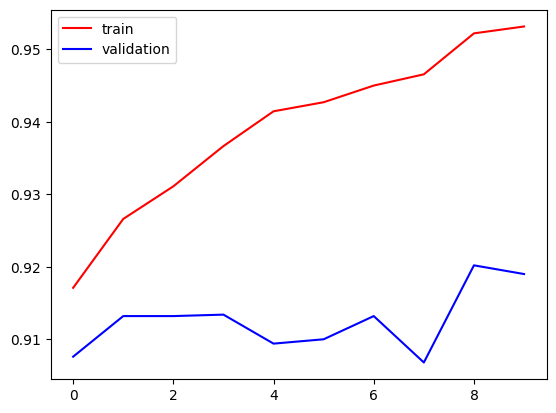

In [75]:
# overfitting reduced significantly as compared to without augmentation model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

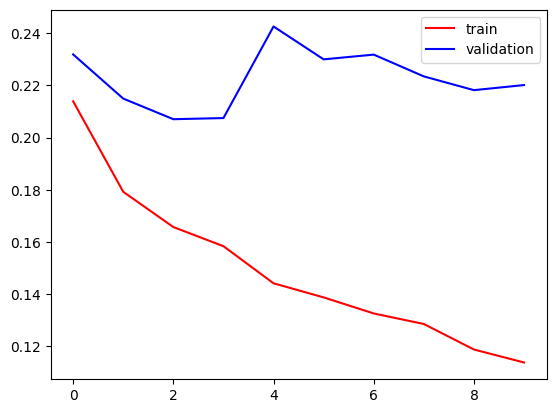

In [76]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [23]:
import cv2

In [57]:
test_img = cv2.imread('/content/dog2.jpg')

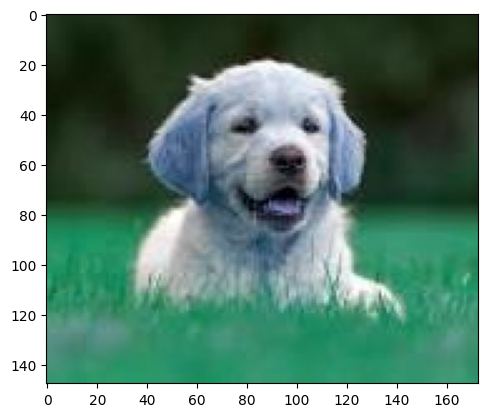

In [58]:
plt.imshow(test_img)

In [59]:
test_img.shape

(148, 173, 3)

In [60]:
test_img = cv2.resize(test_img, (150,150))

In [61]:
test_input = test_img.reshape((1,150,150,3))

In [77]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


array([[1.]], dtype=float32)

In [85]:
test_img2 = cv2.imread('/content/cat2.jpg')

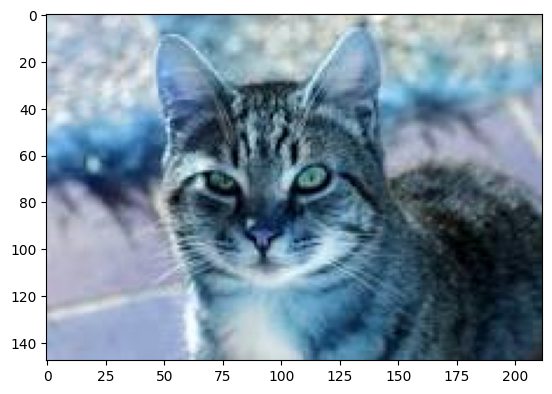

In [86]:
plt.imshow(test_img2)

In [87]:
test_img2.shape

(148, 212, 3)

In [88]:
test_img2 = cv2.resize(test_img2, (150,150))

In [89]:
test_input2 = test_img2.reshape((1,150,150,3))

In [90]:
model.predict(test_input2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[0.]], dtype=float32)